### Import libraries

In [6]:
#https://colab.research.google.com/github/hurrialice/uncertainties/blob/master/mini_regression_ZH1215.ipynb
import sys,os
sys.path.append("../")
import random

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.plots import visualize_uncertainty
from utils.misc import gen_data
from utils.loss import AleatoricLoss
from utils.metrics import mpiw,picp
from model_utils.mlp import MLPNet
from uncertainty.mc_dropout_regression import mc_dropout_eval

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
device="cuda:0"

# Uncertainty modeling


### Network structure and Model Uncertainties

In [9]:
def train_model(
    network,
    X,
    y,
):
    """
    network: an instance of the Net Class
    loss function: an instance of loss Class
    opt: an instance of optimizer class
    """
    optimizer = optim.Adam(network.parameters(), lr=1e-4, weight_decay=0.001)
    number_epochs=80000
    loss_function = AleatoricLoss()
    X = X.to(device)
    y = y.to(device)
    for epoch in tqdm(range(number_epochs)):
        prediction, log_var = network(X)
        loss = loss_function(y, prediction, log_var.to(device))

        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
    
    return network
    
def viz_uncertainty(if_drop, if_ale, fig_title, default_p=0.5):
    if not if_drop: #不要dropout，不考虑epistemic uncertainty
        p = 0
    else:
        p = default_p
    net = MLPNet(p=p, logvar=if_ale ,n_feature=1, n_hidden=32, n_output=1).to(device)
    net = train_model(net,x_train,y_train)
    pred_v, pred_mean,a_u,e_u = mc_dropout_eval(net, x_test.to(device), dropout=if_drop)
    print(picp(pred_v,y_test))
    print(mipw(pred_v, y_test))
    visualize_uncertainty(fig_title,pred_mean,a_u,e_u, x_train, y_train, x_test, y_test)
    
    return net


def vis_three_models(p=0.5):
    _ = viz_uncertainty(False, True, "Aleatoric Only", default_p=p)
    _ = viz_uncertainty(True, False, "Epistemic Only", default_p=p)
    _ = viz_uncertainty(True, True, "Combined", default_p=p)

###  Homoskedastic

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:24<00:00, 302.12it/s]


tensor([0.])
0.0


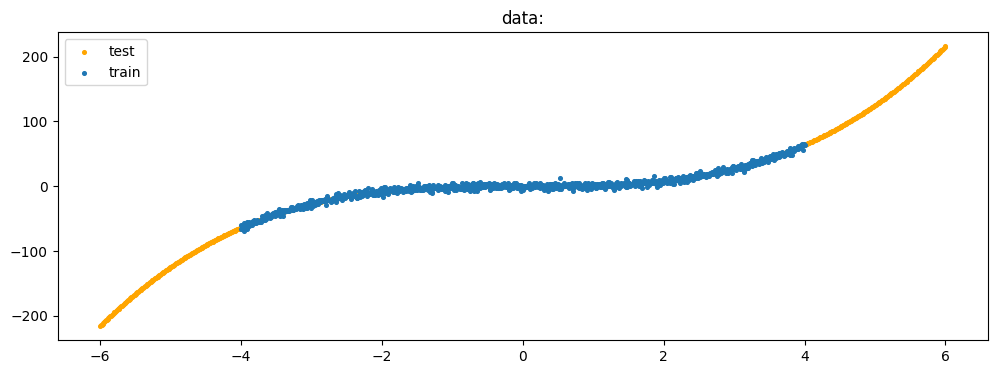

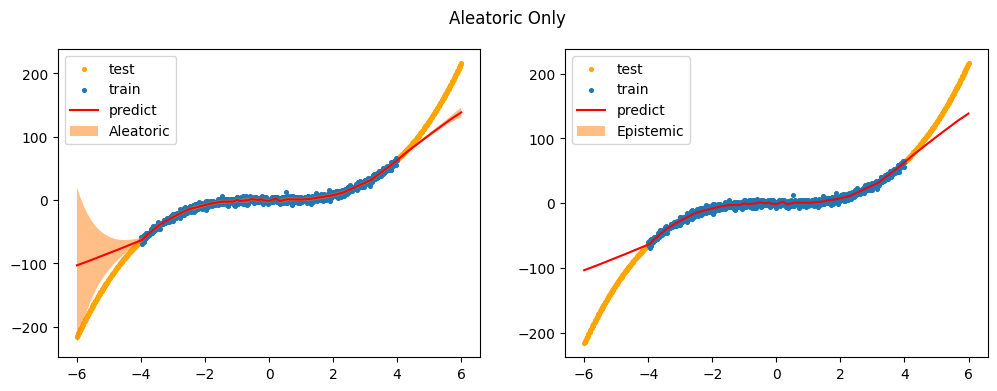

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [03:55<00:00, 339.09it/s]


tensor([0.9670])
51.26529552332162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:29<00:00, 297.19it/s]


tensor([0.8570])
53.39518159997983


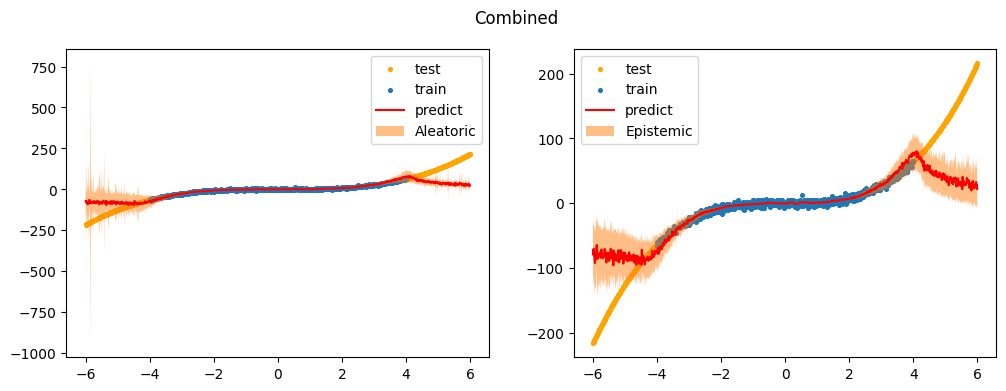

In [10]:
def MEAN_FUN(x): return x**3
x_train, y_train, x_test, y_test = gen_data(
    mean_fun=MEAN_FUN, std_const=3, train_abs=4, test_abs=6)
vis_three_models()#The question is why we have large value for both uncertainty near 0 

### Homoskedastic with Occlusion


100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:37<00:00, 287.88it/s]


tensor([0.])
0.0


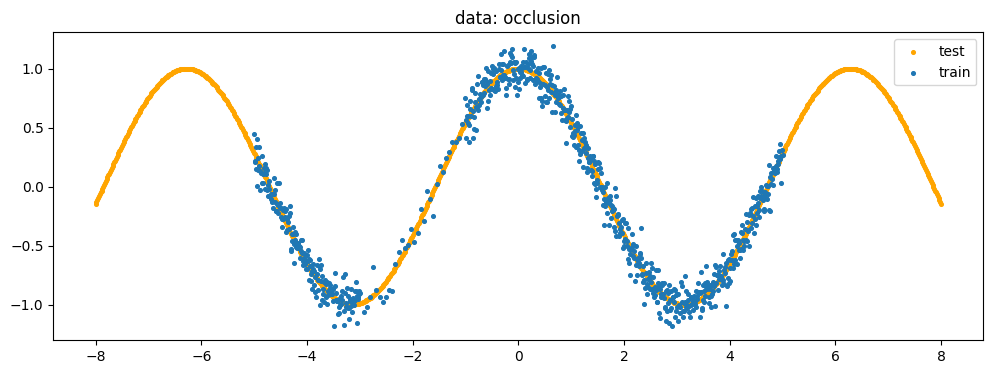

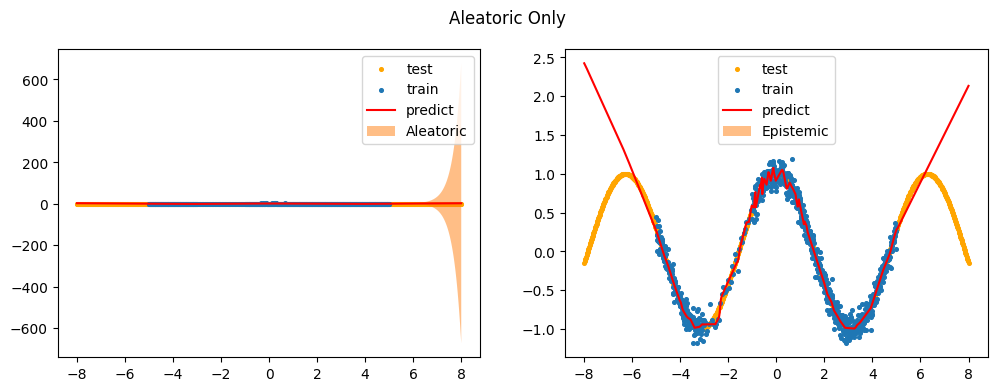

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:19<00:00, 308.74it/s]


tensor([0.7450])
0.613186990694003


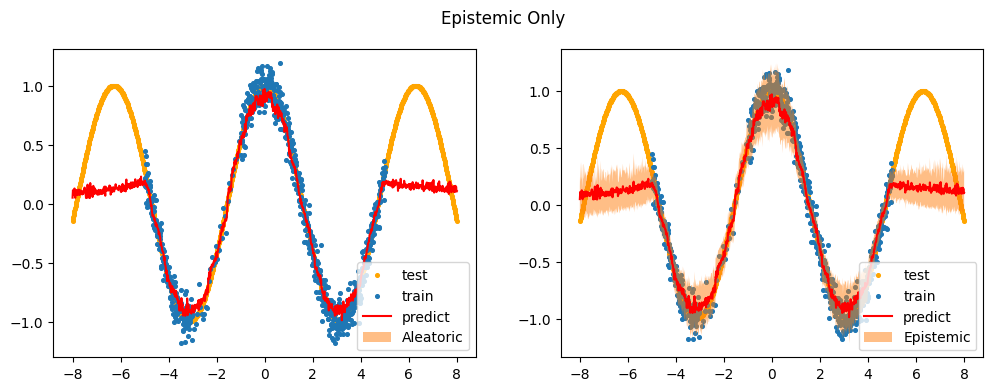

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:38<00:00, 287.01it/s]


tensor([0.7830])
0.6834586001290006


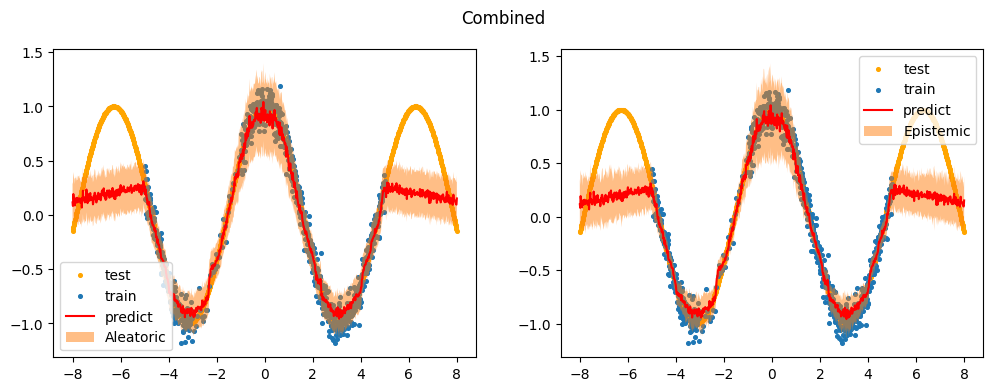

In [6]:
x_train, y_train, x_test, y_test = gen_data(occlude=True, hetero=False)
vis_three_models()#

###  Heteroskedastic data

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:36<00:00, 289.45it/s]


tensor([0.])
0.0


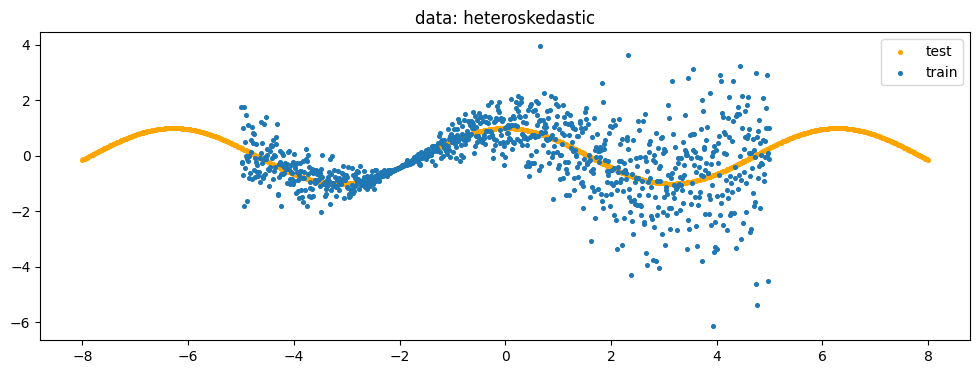

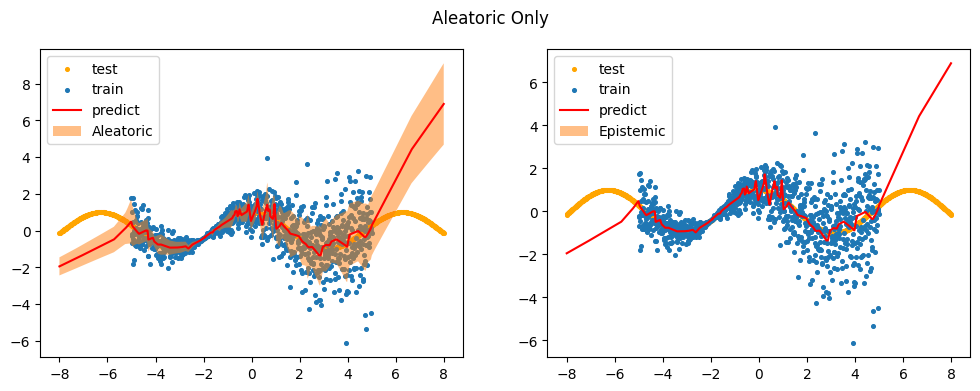

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:22<00:00, 305.15it/s]


tensor([0.6670])
0.6565278238451105


100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:51<00:00, 274.39it/s]


tensor([0.8900])
1.145555810199305


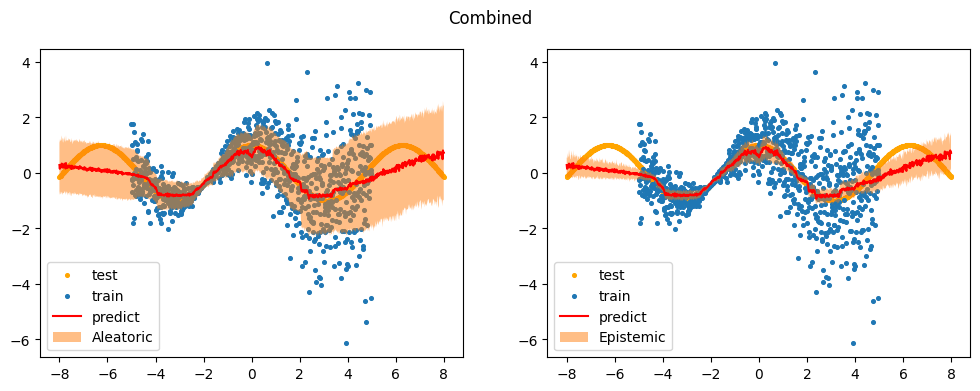

In [7]:
x_train, y_train, x_test, y_test = gen_data(occlude=False, hetero=True)
vis_three_models()#Aleatoric uncertainty increases as the variance of training data increase with X

### Heteroskedastic with Occlusion

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:33<00:00, 292.57it/s]


tensor([0.])
0.0


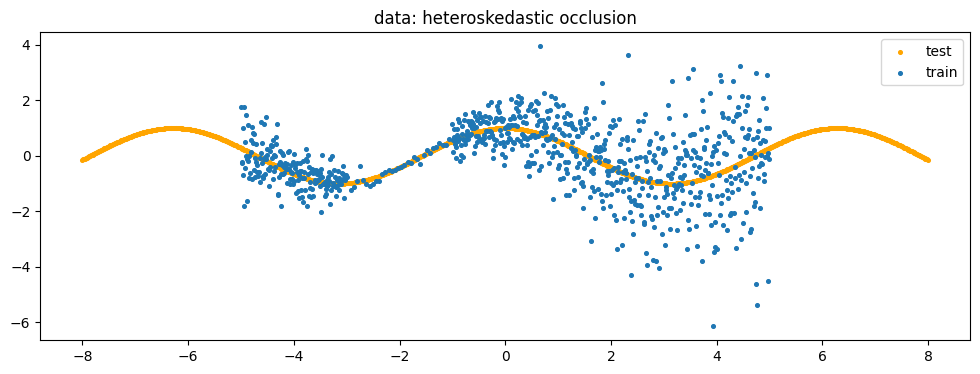

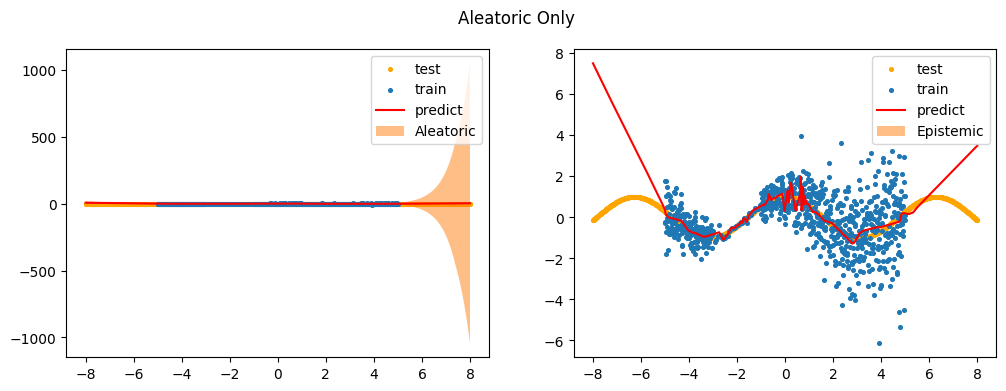

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:16<00:00, 312.27it/s]


tensor([0.6610])
0.6858182660437188


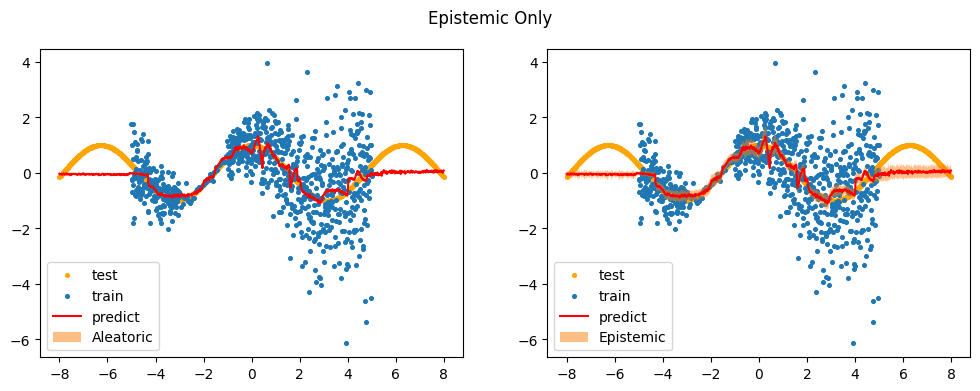

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:49<00:00, 276.32it/s]


tensor([0.7450])
0.9332473070704025


In [8]:
x_train, y_train, x_test, y_test = gen_data(occlude=True, hetero=True)
vis_three_models()

###  Heteroskedastic with sin noise

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:33<00:00, 292.15it/s]


tensor([0.])
0.0


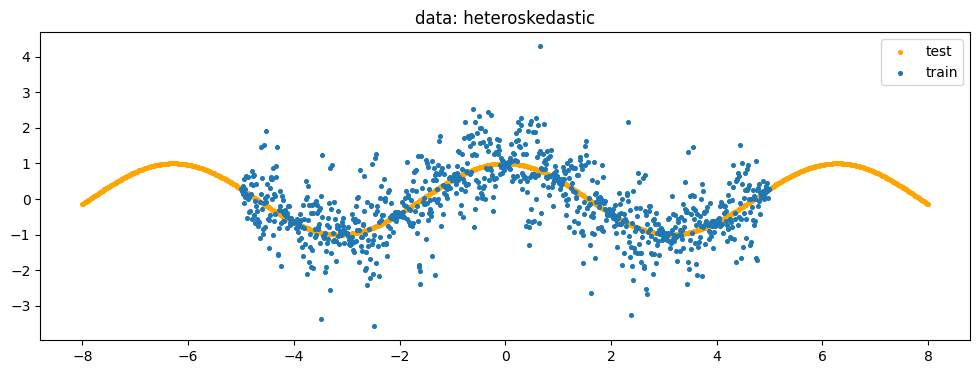

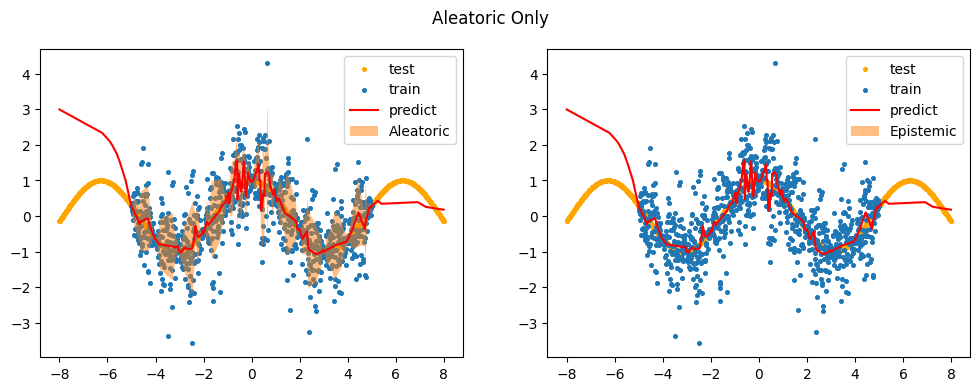

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:04<00:00, 327.19it/s]


tensor([0.7710])
0.8227769016943871


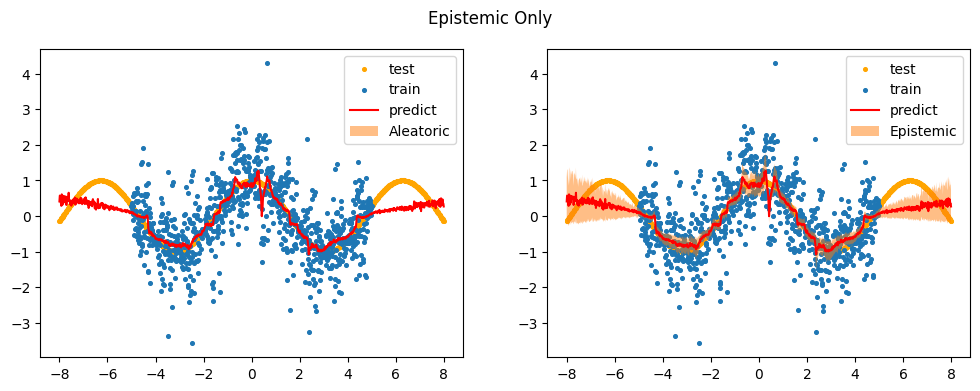

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:40<00:00, 284.79it/s]


tensor([0.7510])
0.767448023801483


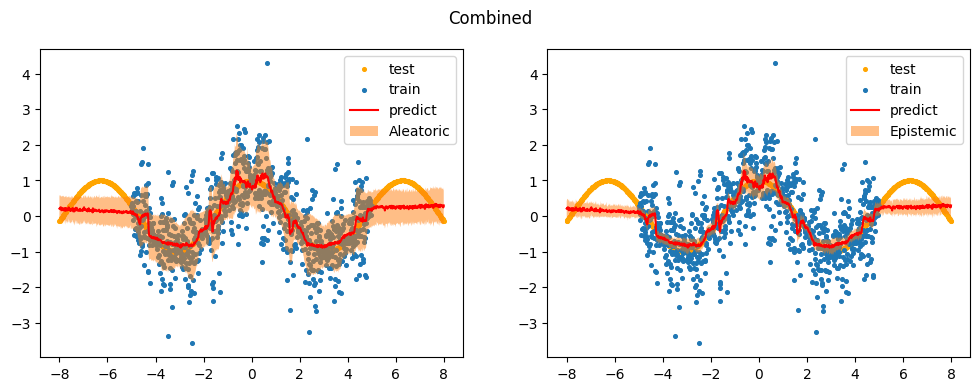

In [9]:
STD_SIN = lambda x: np.sin(2 * np.pi * x / 2)
x_train, y_train, x_test, y_test = gen_data(std_fun=STD_SIN, occlude=False, hetero=True)
vis_three_models()#when both aleatoric and epestemic uncertainties are included, the aleatoric uncertainty is much smoother. 

Here we change the frequency of sin function. The aleatoric uncertainty is still smoother in the model combining both uncertainties than in the model only including aleatoric uncertainty. These results suggest that, when this paper tries to combine the two type of uncertainty in one model, the predicted aleatoric uncertainty becomes less reliable. Interestingly, for the test region not containing any train data (below -2 and above 2), the aleatoric uncertainty is totally different for two different sin function. This also suggest the predicted aleatoric uncertainty is not reliable where the test region is not covered by train data.

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:31<00:00, 294.48it/s]


tensor([0.])
0.0


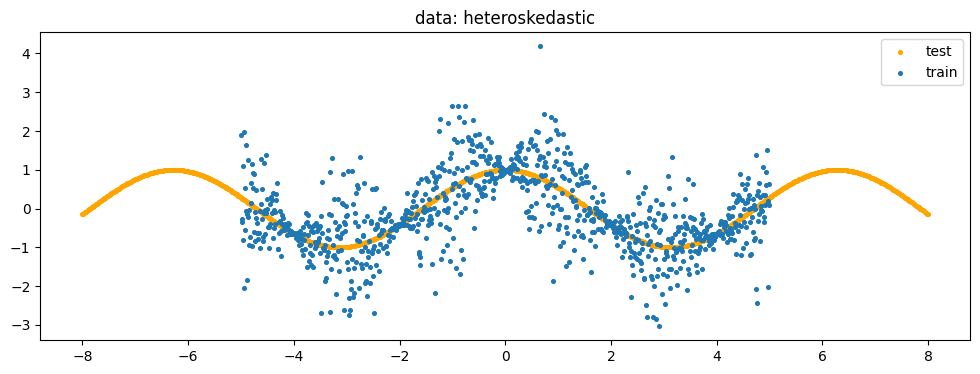

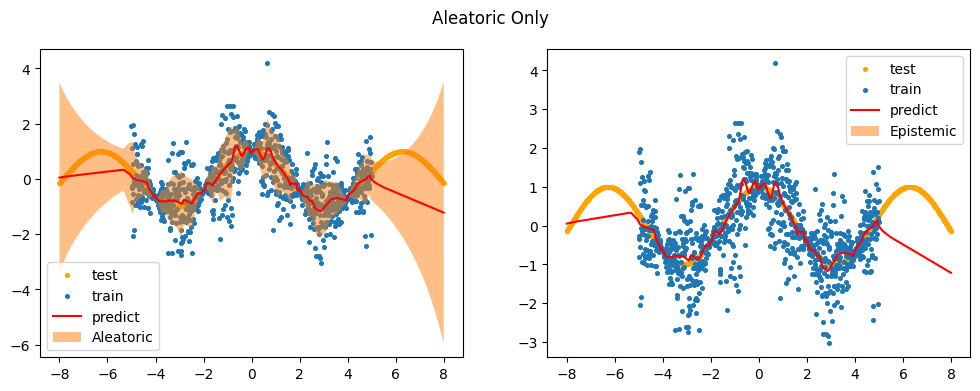

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:05<00:00, 325.25it/s]


tensor([0.7040])
0.6060179308029822


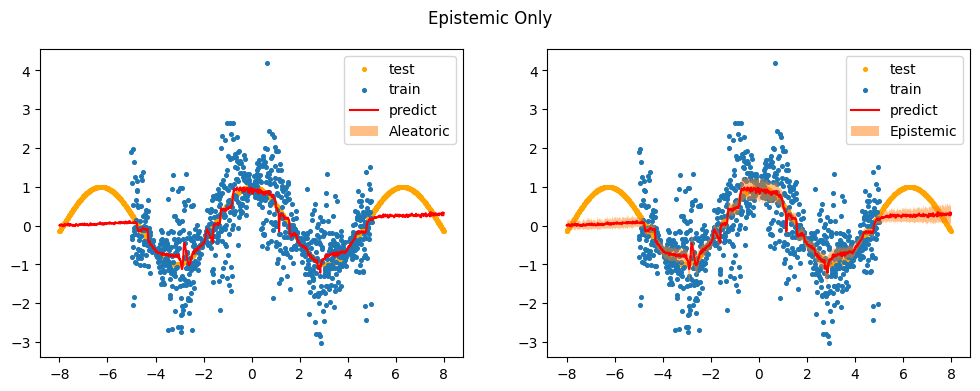

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:38<00:00, 287.40it/s]


tensor([0.7950])
0.8093262411676344


In [10]:
STD_SIN = lambda x: np.sin(2 * np.pi * x / 4)
x_train, y_train, x_test, y_test = gen_data(std_fun=STD_SIN, occlude=False, hetero=True)
vis_three_models()

###  Testing influence of dropout probability

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:32<00:00, 293.67it/s]


tensor([0.])
0.0


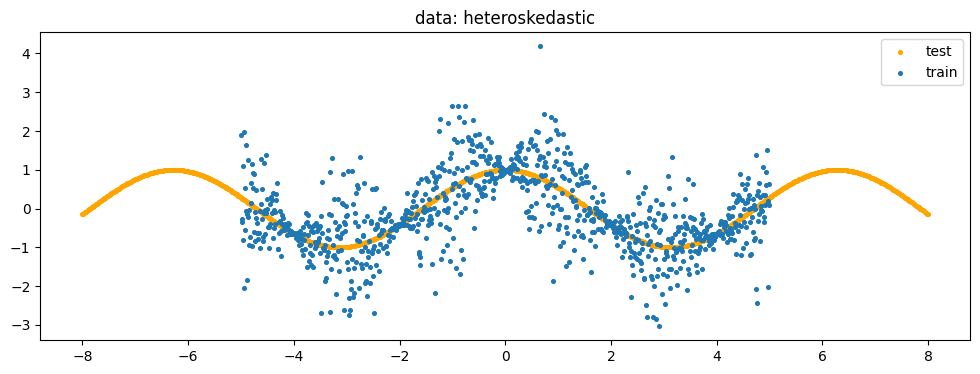

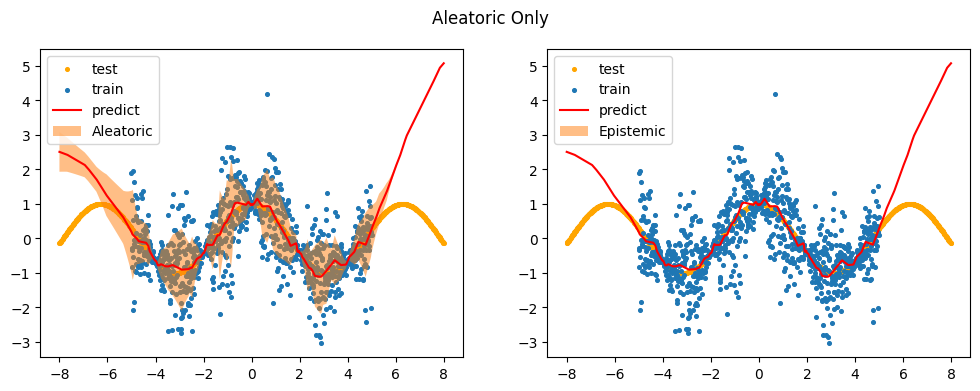

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:05<00:00, 325.58it/s]


tensor([0.6620])
0.9188599104410035


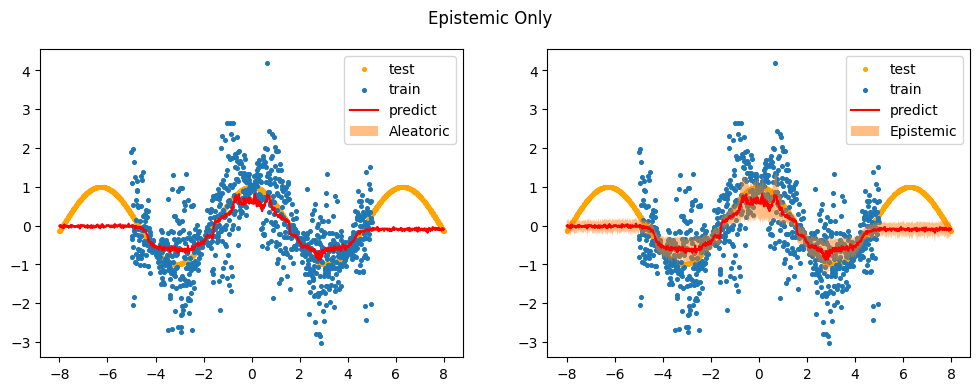

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:38<00:00, 286.75it/s]


tensor([0.8620])
1.1616091692417856


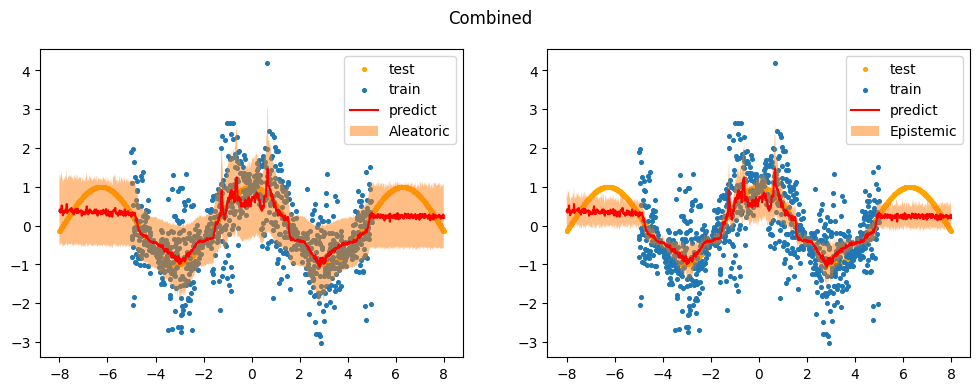

In [11]:
STD_SIN = lambda x: np.sin(2 * np.pi * x / 4)
x_train, y_train, x_test, y_test = gen_data(std_fun=STD_SIN, occlude=False, hetero=True)
vis_three_models(p=0.8)

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:33<00:00, 292.33it/s]


tensor([0.])
0.0


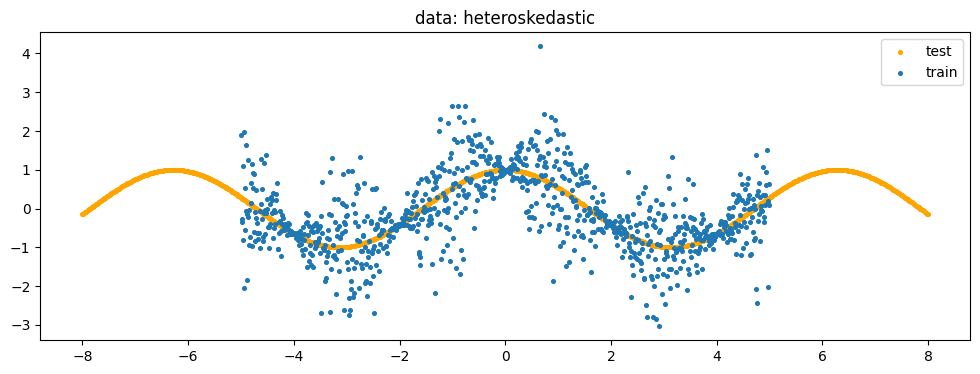

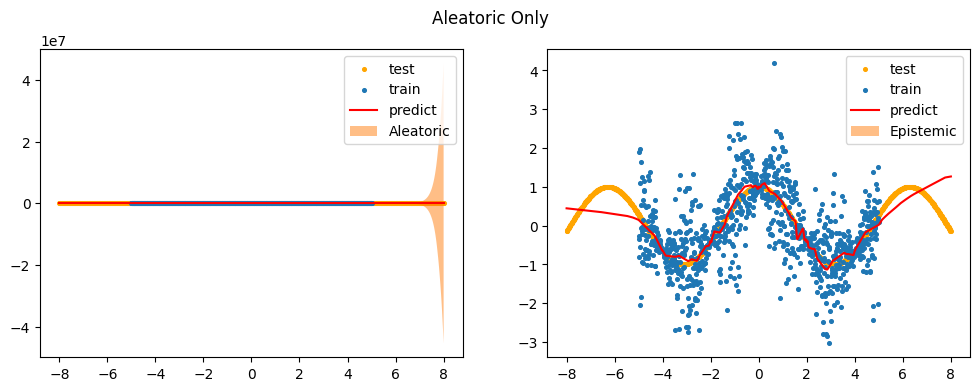

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:06<00:00, 324.74it/s]


tensor([0.6360])
0.47334109964314836


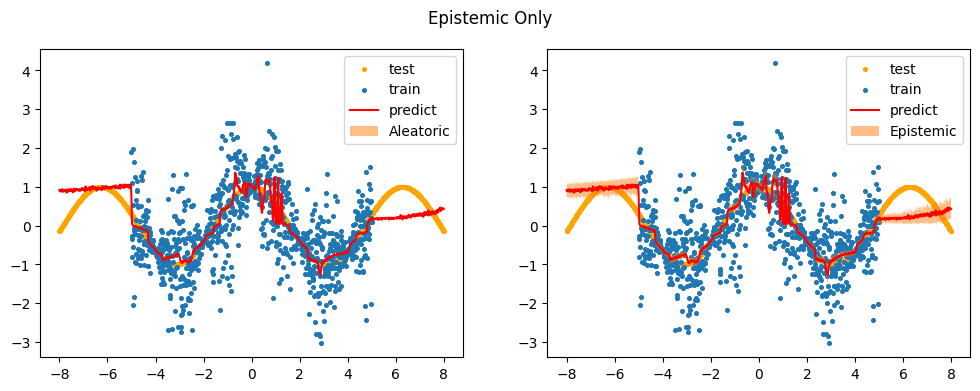

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:38<00:00, 287.65it/s]


tensor([0.6320])
0.5587665578506885


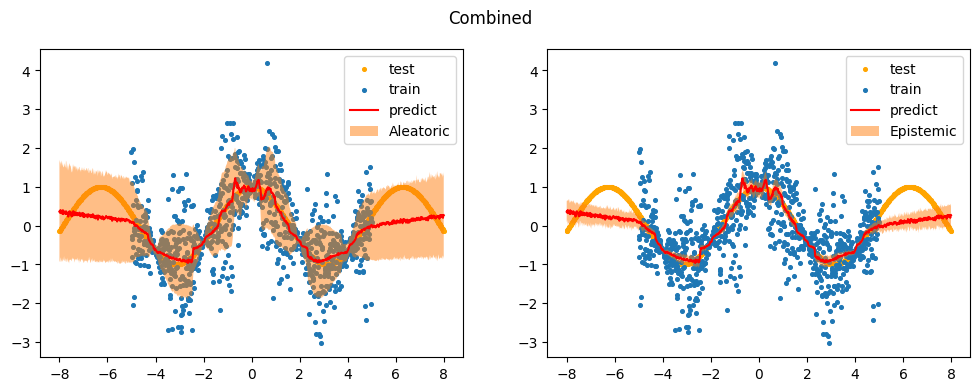

In [12]:
STD_SIN = lambda x: np.sin(2 * np.pi * x / 4)
x_train, y_train, x_test, y_test = gen_data(std_fun=STD_SIN, occlude=False, hetero=True)
vis_three_models(p=0.2)

From the above three examples (including the last example in Case 4) with p = 0.5, 0.8, 0.2 respectively, we can see that, while keeping everything else the same, increasing p leads to larger epistemic uncertainty in the region where training data covers. Interestingly, when p = 0.2, the aleatoric uncertainty in the model combining the two uncertainty well captures the sin-form noise. This suggest as p increases, the aleatoric will get smoother due to the effect of dropout. This intuitively makes sense because when p is very close to zero, there is almost no dropout, epistemic uncertainty should be very small, and aleatoric uncertainty should be very similar to that in the model only considering aleatoric uncertainty. 

### Testing the form of  mean function of test data


100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:32<00:00, 293.07it/s]


tensor([0.])
0.0


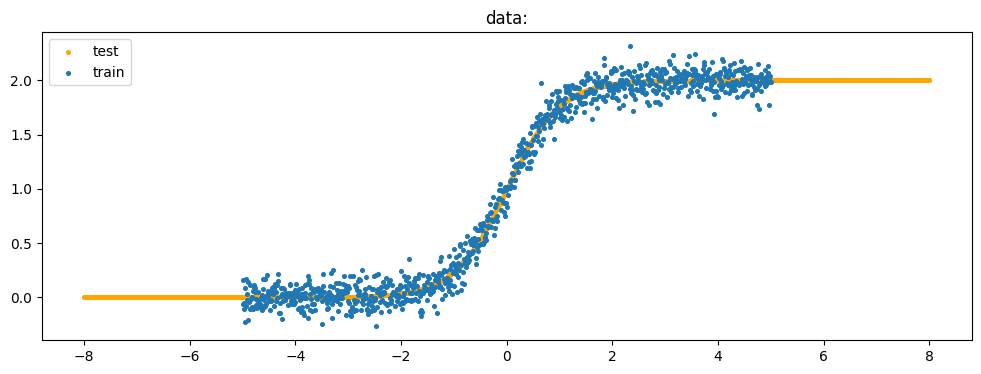

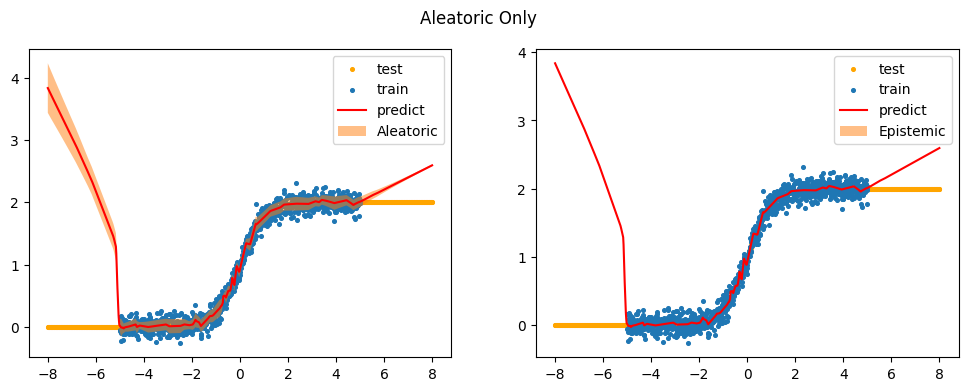

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:03<00:00, 328.02it/s]


tensor([0.9960])
0.8516905459597705


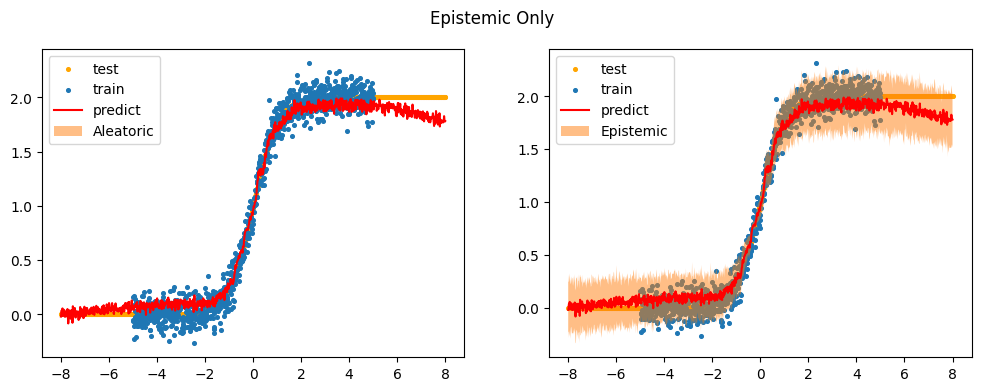

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:39<00:00, 286.21it/s]


tensor([1.])
0.8198131942814215


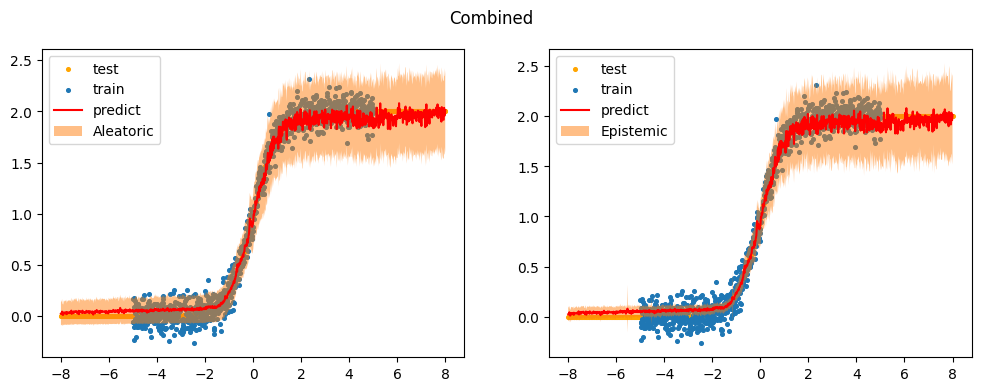

In [13]:
sigmoid = lambda z: 2.0 / (1.0 + np.exp(-2 * z))
x_train, y_train, x_test, y_test = gen_data(mean_fun=sigmoid, occlude=False, hetero=False)
vis_three_models()

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:30<00:00, 296.21it/s]


tensor([0.])
0.0


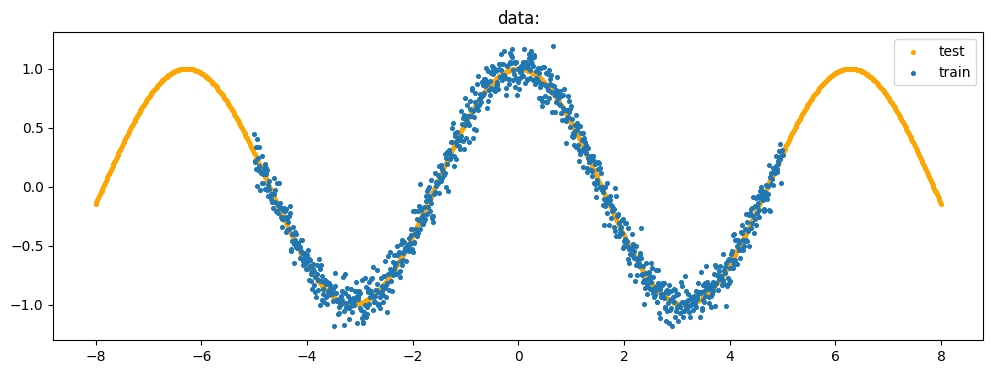

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:07<00:00, 323.64it/s]


tensor([0.0210])
0.10051741039119645


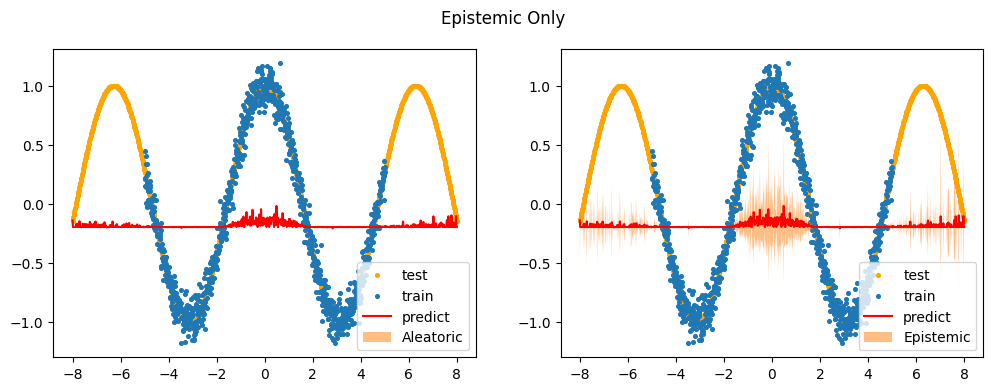

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:41<00:00, 284.65it/s]


tensor([0.])
nan


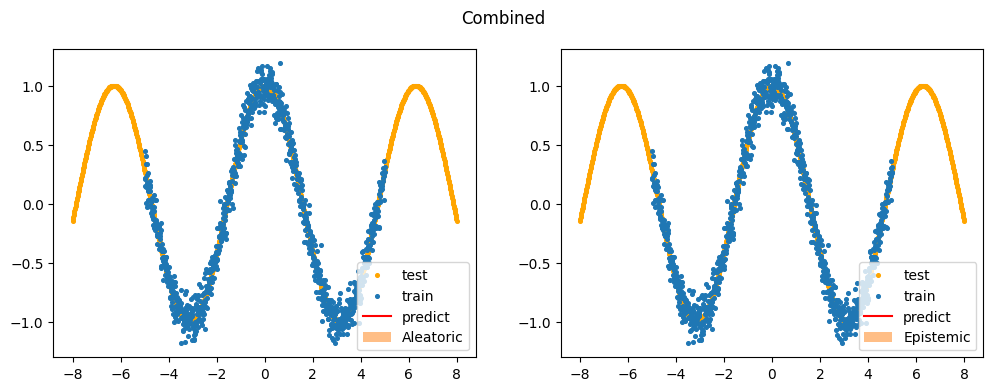

In [14]:
x_train, y_train, x_test, y_test = gen_data(occlude=False, hetero=False)
vis_three_models(p=0.99)

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:30<00:00, 295.64it/s]


tensor([0.])
0.0


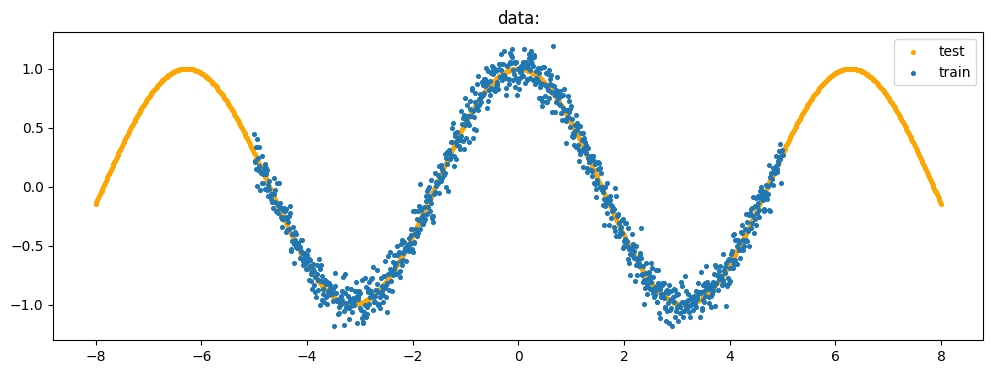

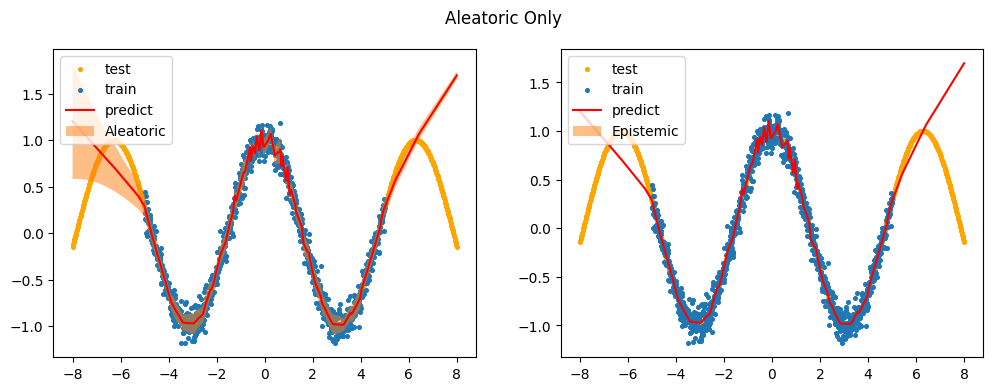

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:07<00:00, 322.67it/s]


tensor([0.])
0.0


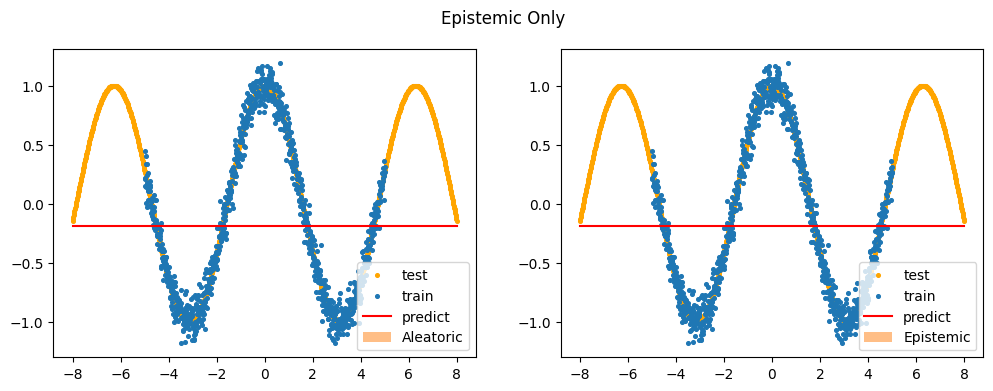

100%|███████████████████████████████████████████████████████████████████████████████████████| 80000/80000 [04:41<00:00, 284.27it/s]


tensor([0.])
0.0


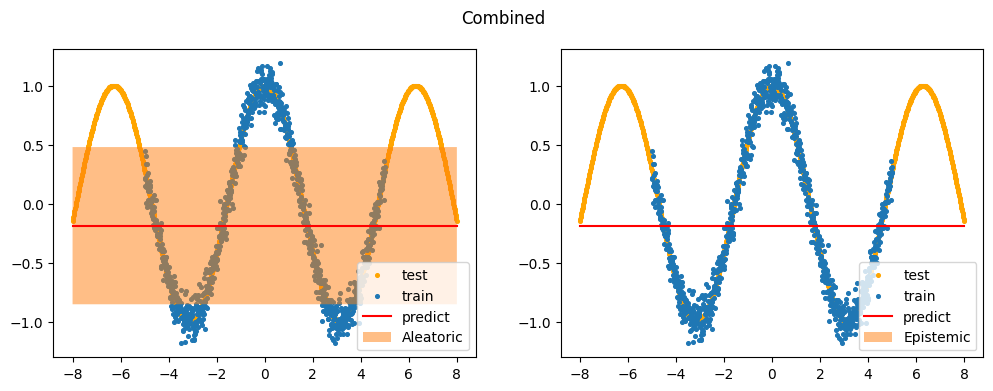

In [15]:
x_train, y_train, x_test, y_test = gen_data(occlude=False, hetero=False)
vis_three_models(p=1)